In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Function
from torchvision import models, transforms
from make_dloader import make_data
from torch.utils.data import DataLoader
from utils import bbox_collate, MixedRandomSampler
import transform as transf
import yaml
import json
from matplotlib import pyplot as plt
import numbers
import torchvision
import torch.optim as optim
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug import parameters as iap
from model import ResNet50
import time
from scipy.ndimage import gaussian_filter
import random

config = yaml.safe_load(open('./config.yaml'))
dataset_means = json.load(open(config['dataset']['mean_file']))

In [2]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

In [3]:
class ModelOutputs():

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


def cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * (1-mask)), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)/255
    cam = cam / np.max(cam)
    return cam
   
def thresh(narray, threshold = 0.15, binary = False):
    if binary:
        return np.where(narray>threshold*np.max(narray), 1, 0)
    return np.where(narray>threshold*np.max(narray), narray, 0)

In [4]:
class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)
        o = torch.sigmoid(output)
        o = o.cpu().data.numpy()
        if index == None:
            o = np.where(o>0.5, 1., 0.)
        label = o.sum(axis = 0)
        #print(label)
        label = np.where(label>o.shape[0]/2, 1., 0.)
        cam_list = []
        for i in range(len(label)):
            if label[i] == 0:
                cam_list.append(0)
                continue
                
            one_hot = np.zeros_like(label)
            one_hot[i] = 1.
            one_hot = torch.from_numpy(one_hot).requires_grad_(True)
            if self.cuda:
                one_hot = torch.sum(one_hot.cuda() * output)
            else:
                one_hot = torch.sum(one_hot * output)
            
            self.feature_module.zero_grad()
            self.model.zero_grad()
            one_hot.backward(retain_graph=True)

            grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

            target = features[-1]
            target = target.cpu().data.numpy() # 40,2048,16,16

            weights = np.mean(grads_val, axis=(2, 3)) #40,2048
            weights = weights[:,:,np.newaxis,np.newaxis] #40,2048,1,1
            cam = np.zeros((target.shape[0], target.shape[2], target.shape[3]), dtype=np.float32) #40,16,16
            target =  weights * target #40,2048,16,16
            target = target.sum(axis=1) #40,16,16
            target = np.maximum(target, 0)
            T = np.zeros((input.shape[0],input.shape[2],input.shape[3]))
            for b in range(input.shape[0]):
                cam = cv2.resize(target[b], input.shape[2:])
                cam = cam - np.min(cam)
                cam = cam / np.max(cam)
                T[b] = cam
            cam_list.append(T)
    
        return label, cam_list


In [5]:
#model = models.resnet50(pretrained=False)
#model.fc = nn.Sequential( nn.Linear(in_features=2048, out_features=4, bias=True) )
model = ResNet50()
model.cuda()
model.load_state_dict(torch.load("/data/unagi0/masaoka/wsod/model/cam/ResNet50_0_1000.pt"))
grad_cam = GradCam(model=model.model, feature_module=model.model.layer4, target_layer_names=["2"], use_cuda=True)

In [6]:
size = config["inputsize"]
val = config["dataset"]["val"]
val.sort()
val = ''.join(map(str,val))
config

{'dataset': {'image_root': '/data/unagi0/masaoka/dataset/capsule/capsule_crop',
  'annotation_file': '/data/unagi0/masaoka/endoscopy/annotations/cleanup0906/capsule_cocoformat.json',
  'split_file': '/data/unagi0/masaoka/endoscopy/annotations/cleanup0906/5-fold.json',
  'mean_file': '/data/unagi0/masaoka/endoscopy/annotations/capsule_mean.json',
  'class_integration': {'new': [{'id': 1, 'name': 'torose lesion'},
    {'id': 2, 'name': 'vascular lesion'},
    {'id': 3, 'name': 'ulcer'}],
   'map': {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 3}},
  'train': [1, 2, 3, 4],
  'val': [0]},
 'negative_ratio': 5,
 'augmentation': {'flip': False,
  'rotate_flip_shear': True,
  'gaussnoise': 1.0,
  'gamma': [0.95, 1.05]},
 'inputsize': 512,
 'n_iteration': 1000,
 'batchsize': 32,
 'learning_rate': 0.0001,
 'warm_up': 200,
 'lr_step': [25000, 40000],
 'weight_decay': 0.0005,
 'save_dir': './result/lr0.0001_ce_bg5_it50000_3class_4_5fold_new',
 'save_freq': 5000}

In [7]:
_, _, _, dataset_val, dataset_all = make_data()
val_anomaly = dataset_val.with_annotation()
#dataset_val = val_anomaly
dataloader_val = DataLoader(dataset_val, num_workers=4, collate_fn=bbox_collate)
unnormalize = transf.UnNormalize(dataset_means['mean'], dataset_means['std'])
normalize = transf.Normalize(dataset_means['mean'], dataset_means['std'])

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!


In [8]:
class loss_r(nn.Module):
    def __init__(self):
        super(loss_r, self).__init__()
        
    def forward(self, i, target, rho = 1e5):
        i = i.cpu().data.numpy()
        target = target.cpu().data.numpy()
        i = np.where(i>0.4,i,0)
        target = np.where(target>0.4,target,0)
        """plt.imshow(i)
        plt.show()
        for x in target:
            plt.imshow(x)
            plt.show()"""
        loss = 255*abs(target-i)/i.sum()
        loss = loss.sum()
        return 0.5*loss*rho
    
class loss_l2(nn.Module):
    def __init__(self):
        super(loss_l2, self).__init__()
    
    def forward(self, i, rho = 1e-4):
        loss = (255*i)**2
        loss = loss.sum()
        return 0.5*rho*loss
    
class loss_tv(nn.Module):
    
    def __init__(self):
        super(loss_tv, self).__init__()
    
    def forward(self, i, rho = 3000):
        w, h = i.shape[0], i.shape[1]
        lx = i[1:, :h-1] - i[ :w-1, :h-1]
        ly = i[:w-1, 1:] - i[:w-1, :h-1]
        lx, ly = abs(lx), abs(ly)
        loss = lx.sum()+ly.sum()
        return rho*loss

In [9]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.l2loss = loss_l2()
        self.TVloss = loss_tv()
        self.r_loss = loss_r()
        
    def forward(self, i, t):
        l2loss = self.l2loss(i)
        TVloss = self.TVloss(i)
        r_loss = self.r_loss(i,t)
        loss = l2loss + TVloss + r_loss
        return TVloss, r_loss, l2loss

In [10]:
def converge_map(masks):
    #init 512,512 ndarray ; mask b,512,512 ndarray
    seq1 = iaa.Sequential([
                    iaa.Affine(
        rotate=iap.DiscreteUniform(-180,179)*(-1)
                    )])
    ia.seed(0)
    masks = seq1(images=masks)
    
    mask_reconvert = torch.from_numpy(masks) #b,512,512 tensor
    mp = mask_reconvert[0]
    """for m in mask_reconvert:
        n = m.squeeze().numpy().copy()
        n = np.where(n>0.5,1,0)
        plt.imshow(n)
        plt.show()"""
    calc_loss = Loss()
    calc_loss.cuda()
    losses = []
    TVloss, r_loss, l2 = calc_loss(mp.cuda(), mask_reconvert.cuda())
    l2 = l2/(size**2)
    TVloss = TVloss/(size**2)
    r_loss = r_loss/masks.shape[0]/(size**2)
    print(f"TV:{TVloss}, r:{r_loss}, l2:{l2}")
    conf_loss = r_loss+TVloss
    mp = mp.data.numpy()
    return mp, conf_loss #512,512 ndarray

In [11]:
def augmented_grad_cam(gcam, image):           #gcamはheatmapとlabelを出力するクラス
    #img.shape=B,C,H,W　tensor
    img = image.clone()
    img = img.squeeze().numpy().transpose(1,2,0)  #512,512,3
    b = 10
    img = np.tile(img,(b,1,1,1)) #b,512,512,3
    seq = iaa.Sequential([
                    iaa.Affine(
        rotate=iap.DiscreteUniform(-180, 179)
                    )])
    ia.seed(0)
    img = seq(images=img)
    img = torch.from_numpy(img)
    labels, masks = grad_cam(img.permute(0,3,1,2), None) #label [1,0,0,0] masks [(40,512,512), 0, (40,512,512), 0]
    maps = []
    for i, label in enumerate(labels):
        if label == 0:
            maps.append(0)
            continue
        elif i == len(labels)-1:
            continue
        else:
            mp, _ = converge_map(masks[i])
            maps.append(mp[np.newaxis,:,:])
    
    return maps
    

In [12]:
class Conf(nn.Module):
    def __init__(self):
        super(Conf, self).__init__()
    def forward(self, x):
        converged, conf = converge_map(x.numpy())
        return converged, conf
    
def calc_conf(masks):
    reconvert = torch.from_numpy(masks) 
    #信頼度の計算をするクラスConf
    conf = Conf() 
    conf.cuda()
    mask, conf = conf(reconvert)
    return mask, conf

def high_conf_maps(gcam, image):           #gcamはheatmapとlabelを出力するクラス
    #img.shape=B,C,H,W　tensor
    img = image.clone()
    img = img.squeeze().numpy().transpose(1,2,0)  #512,512,3
    b = 10
    img = np.tile(img,(b,1,1,1)) #b,512,512,3
    seq = iaa.Sequential([
                    iaa.Affine(
        rotate=iap.DiscreteUniform(-180, 179)
                    )])
    s = iaa.Sequential([iaa.Affine(scale=0.9)])
    img = s(images = img)
    ia.seed(0)
    img = seq(images=img)
    img = torch.from_numpy(img)
    labels, masks = grad_cam(img.permute(0,3,1,2), None) #label [1,0,1] masks [(40,512,512), 0, (40,512,512)]

    maps = []
    eps = 35
    for i, label in enumerate(labels):
        if label == 0:
            maps.append(0)
            continue
        else:
            pseudo_map, conf = calc_conf(masks[i])
            print(f"conf:{conf}")
            if conf < eps:
                maps.append(pseudo_map)
            else:
                maps.append(0)
    return maps

In [13]:
def heatmap2box(heatmap, img=0, threshold = 0.5):
    # img 512,512,3 ndarray,      heatmap  1,512,512 ndarray
    if not isinstance(img, numbers.Number):
        image = img.copy()
    heatmap = thresh(heatmap, threshold = threshold)
    heatmap = heatmap[0]
    heatmap = np.uint8(255*heatmap)
    label = cv2.connectedComponentsWithStats(heatmap)
    n = label[0] - 1
    data = np.delete(label[2], 0, 0)
    boxes = torch.tensor([])
    for i in range(n):
    # 各オブジェクトの外接矩形を赤枠で表示
        x0 = data[i][0]
        y0 = data[i][1]
        x1 = data[i][0] + data[i][2]
        y1 = data[i][1] + data[i][3]
        if boxes.shape[0] == 0:
            boxes = torch.tensor([[x0,y0,x1,y1]])
        else:
            torch.cat((boxes, torch.tensor([[x0,y0,x1,y1]])), dim=0)
        score = threshold
        if not isinstance(img, numbers.Number):
            cv2.rectangle(image, (x0, y0), (x1, y1), (255, 255, 0), thickness = 4)
    #if not isinstance(img, numbers.Number):
    #    plt.imshow(image)
    #    plt.show()
    return boxes, score

def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal7
Normal7
Normal7
Normal7
----------------------------------------
Grad-CAM
torose lesion


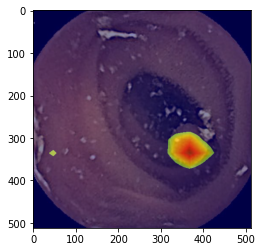

Normal7
Normal7
Normal7
----------------------------------------
Grad-CAM
torose lesion


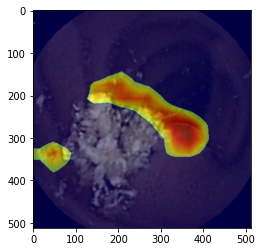

----------------------------------------
Grad-CAM
torose lesion


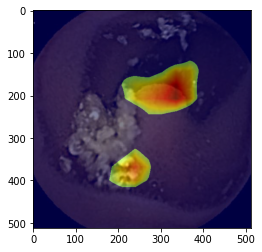

Normal
----------------------------------------
Grad-CAM
torose lesion


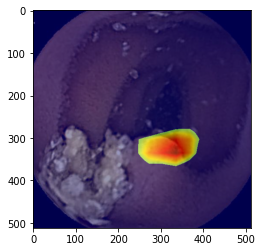

----------------------------------------
Grad-CAM
torose lesion


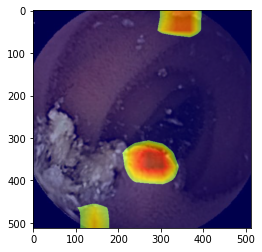

----------------------------------------
Grad-CAM
torose lesion


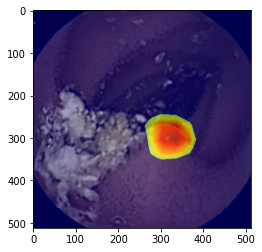

Normal7
Normal7
----------------------------------------
Grad-CAM
torose lesion


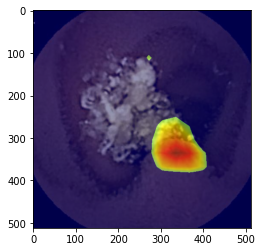

----------------------------------------
Grad-CAM
torose lesion


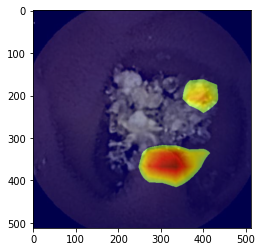

Normal7
Normal7
Normal7
Normal7
Normal7
Normal7
----------------------------------------
Grad-CAM
torose lesion


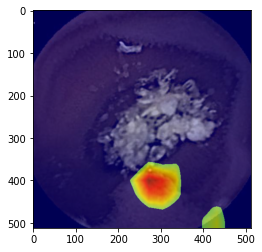

Normal7
Normal7
Normal7
----------------------------------------
Grad-CAM
torose lesion


KeyboardInterrupt: 

In [21]:
count = 0
#通常の評価　マスクなし
threshold= .5
gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
ids = []
for idx, data in enumerate(dataloader_val): 
    
    image = data["img"].clone()
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    label_name = "normal"
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
    """if label_name != "ulcer":
        continue"""
        
    """maps = high_conf_maps(grad_cam, image)
    image = data["img"].clone()
    for m in maps:
        if not isinstance(m, numbers.Number):
            mask_thresh = thresh(m, threshold = threshold)
            m = cam_on_image(image.squeeze().numpy().transpose(1,2,0), mask_thresh)
            plt.imshow(m)
            plt.show()
            ids.append(idx)
            break"""
    masks = grad_cam(image, None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn=(1-output)*(1-target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            if flag == 3:
                print("Normal")
            continue
        print("----------------------------------------")
        print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 1,512,512
        heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad1 = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad1, threshold = threshold)
        plt.imshow(grad1)
        plt.show()
        grad1 = cv2.cvtColor(grad1, cv2.COLOR_BGR2RGB)
        #cv2.imwrite(f"/data/unagi0/masaoka/w_o_mask_grad_cam/{idx}_{num}.png", np.uint8(255*grad1))
    #print("------------------------------------")
    """print("Augmented Grad-CAM")
    for num, mask in enumerate(masksa):
        if isinstance(mask,numbers.Number):
            continue
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        else:
            print("Normal")
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad, threshold = threshold)
        plt.imshow(grad)
        plt.show()"""
    #print("-------------------------------------")
    #print("Ground Truth")
    #plt.imshow(img)
    #plt.show()
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255,0, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        #print(label_name)

    """plt.imshow(img)
    plt.show()"""
    
    

In [19]:
print(tpa,gt-tpa,fpa,tna)

[795.  48.  70.] [187.  27.   6.] [1266.   11.    0.] [4799. 6961. 6971.]


In [30]:
#通常の評価　マスクなし
threshold= .5
gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
ids = []
for idx, data in enumerate(dataloader_val): 
    image = data["img"].clone()
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    label_name = "normal"
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
    if label_name != "ulcer":
        continue
        
    maps = high_conf_maps(grad_cam, image)
    image = data["img"].clone()
    for m in maps:
        if not isinstance(m, numbers.Number):
            mask_thresh = thresh(m, threshold = threshold)
            """m = cam_on_image(image.squeeze().numpy().transpose(1,2,0), mask_thresh)
            plt.imshow(m)
            plt.show()"""
            ids.append(idx)
            break
    masks = grad_cam(image, None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn=(1-output)*(1-target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            if flag == 3:
                print("Normal")
            continue
        print("----------------------------------------")
        print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 1,512,512
        heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad1 = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad1, threshold = threshold)
        plt.imshow(grad1)
        plt.show()
        grad1 = cv2.cvtColor(grad1, cv2.COLOR_BGR2RGB)
        #cv2.imwrite(f"/data/unagi0/masaoka/w_o_mask_grad_cam/{idx}_{num}.png", np.uint8(255*grad1))
    #print("------------------------------------")
    """print("Augmented Grad-CAM")
    for num, mask in enumerate(masksa):
        if isinstance(mask,numbers.Number):
            continue
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        else:
            print("Normal")
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad, threshold = threshold)
        plt.imshow(grad)
        plt.show()"""
    #print("-------------------------------------")
    #print("Ground Truth")
    #plt.imshow(img)
    #plt.show()
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        #print(label_name)

        
    plt.imshow(img)
    plt.show()

RuntimeError: Unable to find a valid cuDNN algorithm to run convolution (try_all at /opt/conda/conda-bld/pytorch_1587428132279/work/aten/src/ATen/native/cudnn/Conv.cpp:693)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x4e (0x7f55b4030b5e in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0xe54bbd (0x7f55b50b1bbd in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #2: <unknown function> + 0xe55701 (0x7f55b50b2701 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #3: <unknown function> + 0xe5973b (0x7f55b50b673b in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #4: at::native::cudnn_convolution_backward_input(c10::ArrayRef<long>, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool) + 0xb2 (0x7f55b50b6c92 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xec07b0 (0x7f55b511d7b0 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xf05048 (0x7f55b5162048 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #7: at::native::cudnn_convolution_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool, std::array<bool, 2ul>) + 0x4fa (0x7f55b50b832a in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #8: <unknown function> + 0xec0adb (0x7f55b511dadb in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #9: <unknown function> + 0xf050a4 (0x7f55b51620a4 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #10: <unknown function> + 0x29defc6 (0x7f55d8676fc6 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0x2a2ea54 (0x7f55d86c6a54 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #12: torch::autograd::generated::CudnnConvolutionBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x378 (0x7f55d828ef28 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #13: <unknown function> + 0x2ae8215 (0x7f55d8780215 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #14: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7f55d877d513 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #15: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7f55d877e2f2 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #16: torch::autograd::Engine::thread_init(int) + 0x39 (0x7f55d8776969 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #17: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7f55dbab79f8 in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #18: <unknown function> + 0xc819d (0x7f561b48719d in /home/mil/masaoka/.pyenv/versions/anaconda3-2019.10/envs/cuda9/lib/python3.8/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #19: <unknown function> + 0x76ba (0x7f561e44b6ba in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #20: clone + 0x6d (0x7f561e18141d in /lib/x86_64-linux-gnu/libc.so.6)


In [ ]:
#通常の評価　d_val_conf のみ

gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
for idx, data in enumerate(dataloader_val): 
    if idx > ids[-1]:
        break
    if not (idx in ids):
        continue
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        #print(label_name)
    image = data["img"].clone()
    masks = grad_cam(image, None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    image = data["img"].clone()
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn = (1 - output) * (1 - target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            """if flag == 3:
                print("Normal")"""
            continue
        print("----------------------------------------")
        print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 1,512,512
        #heatmap2box(mask, img=img, threshold = threshold)
        """mask_thresh = thresh(mask, threshold = threshold)
        grad1 = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad1, threshold = threshold)
        plt.imshow(grad1)
        plt.show()
        grad1 = cv2.cvtColor(grad1, cv2.COLOR_BGR2RGB)"""
        #cv2.imwrite(f"/data/unagi0/masaoka/w_o_mask_grad_cam/{idx}_{num}.png", np.uint8(255*grad1))
    #print("------------------------------------")
    """print("Augmented Grad-CAM")
    for num, mask in enumerate(masksa):
        if isinstance(mask,numbers.Number):
            continue
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        else:
            print("Normal")
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad, threshold = threshold)
        plt.imshow(grad)
        plt.show()"""
    #print("-------------------------------------")
    #print("Ground Truth")
    #plt.imshow(img)
    #plt.show()
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        #print(label_name)
        
    """plt.imshow(img)
    plt.show()"""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #cv2.imwrite(f"/data/unagi0/masaoka/w_o_mask_normal/{idx}_{label}.png", img)

In [ ]:
print(tpa,gt-tpa,fpa,tna)
print(tpa/(gt), tna/(tna+fpa))

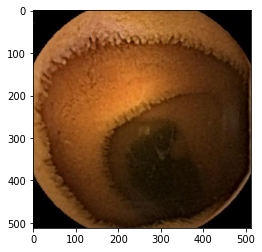

[0. 0. 0.] [1. 0. 0.] [0. 0. 0.] [0. 1. 1.]


In [15]:
#腫瘍にマスク、正常画像はランダムにマスク
threshold = 0.5
gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
all_masks = []
size = config["inputsize"]
for idx, data in enumerate(dataloader_val): 
    image = data["img"].clone()
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    mask = torch.ones((size,size))
    flag = -1
    for i in range(len(data["bboxes"][0])):
        flag = 1
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        mask[y1:y2,x1:x2] = 0
        inv_mask = 1 - mask
        if (y2-y1)*(x2-x1) < size*size/4:
            all_masks.append(mask)
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        #print(label_name)
    if flag != 1:
        mask = random.choice(all_masks)
        inv_mask = 1 - mask
        
    #blur = gaussian_filter(image*inv_mask,10)
    blur = 0
    image_mask = image*mask
    image = image_mask+ blur
    masks = grad_cam(image, None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn = (1 - output) * (1 - target)
    tpa += tp
    fpa += fp
    tna += tn
    
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    """for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            if flag == 3:
                print("Normal")
            continue
        #print("----------------------------------------")
        #print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 1,512,512
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad1 = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad1, threshold = threshold)
        grad1 = cv2.cvtColor(grad1, cv2.COLOR_BGR2RGB)"""
        #cv2.imwrite(f"/data/unagi0/masaoka/w_mask_grad_cam/{idx}_{num}.png", np.uint8(255*grad1))
    #print("------------------------------------")
    """print("Augmented Grad-CAM")
    for num, mask in enumerate(masksa):
        if isinstance(mask,numbers.Number):
            continue
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        else:
            print("Normal")
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad, threshold = threshold)
        plt.imshow(grad)
        plt.show()"""
    #print("-------------------------------------")
    #print("Ground Truth")
    #plt.imshow(img)
    #plt.show()
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #cv2.imwrite(f"/data/unagi0/masaoka/w_mask_normal/{idx}_{label}.png", img)
    break
print(tpa, gt-tpa,fpa, tna)

In [ ]:
[370.   0.  95.] [403. 151.   0.] [1473.    5.    0.] [5564. 7654. 7715.]

In [ ]:
#腫瘍にマスク、正常画像はランダムにマスク
gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
all_masks = []
size = config["inputsize"]
for idx, data in enumerate(dataloader_val): 
    if idx > ids[-1]:
        break
    if not (idx in ids):
        continue
    image = data["img"].clone()
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    mask = torch.ones((size,size))
    flag = -1
    for i in range(len(data["bboxes"][0])):
        flag = 1
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        mask[y1:y2,x1:x2] = 0
        inv_mask = 1 - mask
        if (y2-y1)*(x2-x1) < size*size/4:
            all_masks.append(mask)
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        #print(label_name)
    if flag != 1:
        mask = random.choice(all_masks)
        inv_mask = 1 - mask
        
    blur = gaussian_filter(image*inv_mask,10)
    image_mask = image*mask
    image = image_mask+ blur
    masks = grad_cam(image, None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn = (1 - output) * (1 - target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            """if flag == 3:
                print("Normal")"""
            continue
        #print("----------------------------------------")
        #print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 1,512,512
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad1 = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad1, threshold = threshold)
        grad1 = cv2.cvtColor(grad1, cv2.COLOR_BGR2RGB)
        #cv2.imwrite(f"/data/unagi0/masaoka/w_mask_grad_cam/{idx}_{num}.png", np.uint8(255*grad1))
    #print("------------------------------------")
    """print("Augmented Grad-CAM")
    for num, mask in enumerate(masksa):
        if isinstance(mask,numbers.Number):
            continue
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        else:
            print("Normal")
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad, threshold = threshold)
        plt.imshow(grad)
        plt.show()"""
    #print("-------------------------------------")
    #print("Ground Truth")
    #plt.imshow(img)
    #plt.show()
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
#腫瘍を切り出し表示、正常画像はランダムに切り出し表示

gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
all_masks = []
for idx, data in enumerate(dataloader_val): 
    image = data["img"].clone()
    print(f'{idx}/{len(dataloader_val)}', end = '\n')
    mask = torch.zeros((size, size))
    flag = 0
    for i in range(len(data["bboxes"][0])):
        flag = 1
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        mask[y1:y2,x1:x2] = 1
        inv_mask = 1 - mask
        if (y2-y1)*(x2-x1) < size*size/4:
            all_masks.append(mask) 
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        #print(label_name)
    if flag ==0:
        mask = random.choice(all_masks)
        inv_mask = 1 - mask
    blur = gaussian_filter(image*inv_mask,10)
    image = image*mask
    image = image + blur
    masks = grad_cam(image, None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn = (1 - output) * (1 - target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            """if flag == 3:
                print("Normal")"""
            continue
        """print("----------------------------------------")
        print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")"""
        #mask 1,512,512
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad1 = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad1, threshold = threshold)
        grad1 = cv2.cvtColor(grad1, cv2.COLOR_BGR2RGB)
        #cv2.imwrite(f"/data/unagi0/masaoka/tumor_only_grad_cam/{idx}_{num}.png", np.uint8(255*grad1))
    #print("------------------------------------")
    """print("Augmented Grad-CAM")
    for num, mask in enumerate(masksa):
        if isinstance(mask,numbers.Number):
            continue
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        else:
            print("Normal")
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad, threshold = threshold)
        plt.imshow(grad)
        plt.show()"""
    #print("-------------------------------------")
    #print("Ground Truth")
    #plt.imshow(img)
    #plt.show()
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        


In [ ]:
#腫瘍を切り出し表示、正常画像はランダムに切り出し表示

gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
all_masks = []
for idx, data in enumerate(dataloader_val): 
    if not (idx in ids):
        continue
    image = data["img"].clone()
    print(f'{idx}/{len(dataloader_val)}', end = '\n')
    mask = torch.zeros((size, size))
    flag = 0
    for i in range(len(data["bboxes"][0])):
        flag = 1
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        mask[y1:y2,x1:x2] = 1
        inv_mask = 1 - mask
        if (y2-y1)*(x2-x1) < size*size/4:
            all_masks.append(mask) 
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        #print(label_name)
    if flag ==0:
        mask = random.choice(all_masks)
        inv_mask = 1 - mask
    blur = gaussian_filter(image*inv_mask,10)
    image = image*mask
    image = image + blur
    masks = grad_cam(image, None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn = (1 - output) * (1 - target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            """if flag == 3:
                print("Normal")"""
            continue
        """print("----------------------------------------")
        print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")"""
        #mask 1,512,512
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad1 = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad1, threshold = threshold)
        grad1 = cv2.cvtColor(grad1, cv2.COLOR_BGR2RGB)
        #cv2.imwrite(f"/data/unagi0/masaoka/tumor_only_grad_cam/{idx}_{num}.png", np.uint8(255*grad1))
    #print("------------------------------------")
    """print("Augmented Grad-CAM")
    for num, mask in enumerate(masksa):
        if isinstance(mask,numbers.Number):
            continue
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        else:
            print("Normal")
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad, threshold = threshold)
        plt.imshow(grad)
        plt.show()"""
    #print("-------------------------------------")
    #print("Ground Truth")
    #plt.imshow(img)
    #plt.show()
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        

In [ ]:
#通常の評価　d_val_conf のみ
gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
threshold = 0.5
for idx, data in enumerate(dataloader_val): 
    if idx > ids[-1]:
        break
    if not (idx in ids):
        continue
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        #print(label_name)
    image = data["img"].clone()
    masks = grad_cam(image, None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    image = data["img"].clone()
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn = (1 - output) * (1 - target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            """if flag == 3:
                print("Normal")"""
            continue
        print("----------------------------------------")
        print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 1,512,512
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad1 = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad1, threshold = threshold)
        plt.imshow(grad1)
        plt.show()
        grad1 = cv2.cvtColor(grad1, cv2.COLOR_BGR2RGB)
        #cv2.imwrite(f"/data/unagi0/masaoka/w_o_mask_grad_cam/{idx}_{num}.png", np.uint8(255*grad1))
    #print("------------------------------------")
    """print("Augmented Grad-CAM")
    for num, mask in enumerate(masksa):
        if isinstance(mask,numbers.Number):
            continue
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        else:
            print("Normal")
        #heatmap2box(mask, img=img, threshold = threshold)
        mask_thresh = thresh(mask, threshold = threshold)
        grad = cam_on_image(img, mask_thresh[0])
        heatmap2box(mask, img=grad, threshold = threshold)
        plt.imshow(grad)
        plt.show()"""
    #print("-------------------------------------")
    #print("Ground Truth")
    #plt.imshow(img)
    #plt.show()
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        #print(label_name)
        
    plt.imshow(img)
    plt.show()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [113]:
_, dataset_val, _ = make_data()
dataloader_val = DataLoader(dataset_val, num_workers=4, collate_fn=bbox_collate)
unnormalize = transf.UnNormalize(dataset_means['mean'], dataset_means['std'])
normalize = transf.Normalize(dataset_means['mean'], dataset_means['std'])

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!


torose lesion


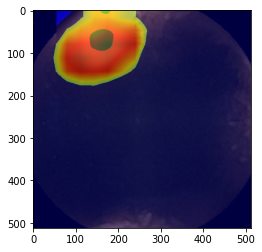

torose lesion


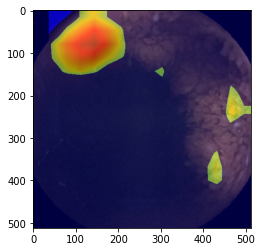

torose lesion


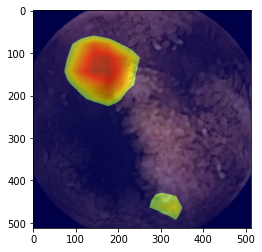

torose lesion


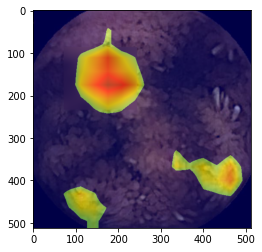

torose lesion


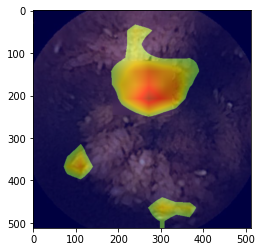

torose lesion


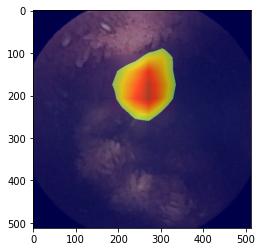

torose lesion


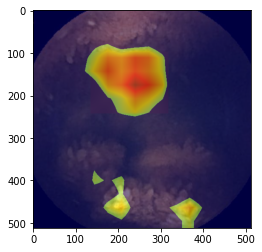

torose lesion


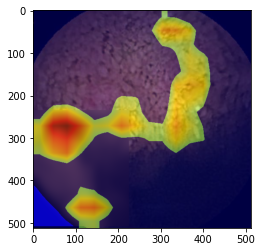

torose lesion


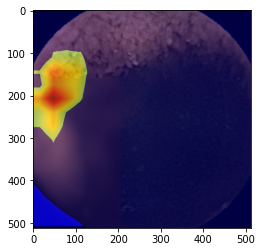

torose lesion


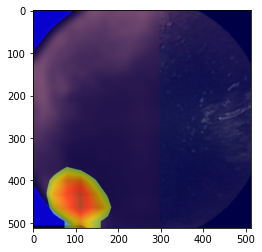

torose lesion


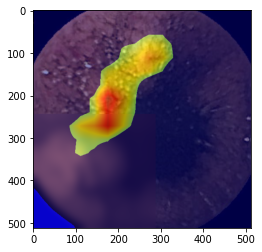

torose lesion


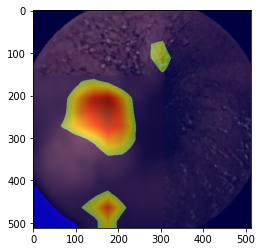

torose lesion


KeyboardInterrupt: 

In [114]:
threshold = 0.5
#腫瘍にマスク、正常画像はランダムにマスク
gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
all_masks = []
size = config["inputsize"]
for idx, data in enumerate(dataloader_val): 
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    """if idx > ids[-1]:
        break
    if not (idx in ids):
        continue"""
    mask = torch.ones((size,size))
    flag = -1
    for i in range(len(data["bboxes"][0])):
        flag = 1
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        mask[y1:y2,x1:x2] = 0
        inv_mask = 1 - mask
        if (y2-y1)*(x2-x1) < size*size/8:
            all_masks.append(mask)
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        #print(label_name)
    if flag != 1:
        mask = random.choice(all_masks)
        inv_mask = 1 - mask
    blur = 0
    #blur = gaussian_filter(data["img"],10)
    blur = inv_mask*blur
    image_mask = data["img"]*mask
    data["img"] = image_mask+blur
    
    
    masks = grad_cam(data["img"], None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn = (1 - output) * (1 - target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            """if flag == 3:
                print("Normal")"""
            continue
        #print("----------------------------------------")
        #print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 1,512,512
        if tp.sum()>0:
            mask_thresh = thresh(mask, threshold = threshold)
            grad1 = cam_on_image(img, mask_thresh[0])
            heatmap2box(mask, img=grad1, threshold = threshold)
            plt.imshow(grad1)
            plt.show()
        
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        
    
    
    """print(label_name)
    plt.imshow(img)
    plt.show()"""
"""path = f'/data/unagi0/masaoka/wsod/text/val{val}.txt'
with open(path, mode='w') as f:
    f.write('masking anomaly\n')
    f.write(f'TP: {tpa}, FN: {gt-tpa}, FP: {fpa},TN: {tna}\n')
    f.write(f'Precision: {tpa/(tpa+fpa+1e-10)}, Recall: {tpa/(gt+1e-10)}, Spec: {tna/(tna+fpa+1e-10)}\n')"""

In [30]:
print(tpa, gt-tpa, fpa, tna)
print(val)

[370.   0.  95.] [403. 151.   0.] [1448.    8.    0.] [5589. 7651. 7715.]
4


In [ ]:
threshold = 0.5
#腫瘍切り出し
gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
all_masks = []
size = config["inputsize"]
for idx, data in enumerate(dataloader_val): 
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    """if idx > ids[-1]:
        break
    if not (idx in ids):
        continue"""
    mask = torch.zeros((size,size))
    flag = -1
    for i in range(len(data["bboxes"][0])):
        flag = 1
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        mask[y1:y2,x1:x2] = 1
        inv_mask = 1 - mask
        if (y2-y1)*(x2-x1) < size*size/8:
            all_masks.append(mask)
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        #print(label_name)
    if flag != 1:
        mask = random.choice(all_masks)
        inv_mask = 1 - mask
    #blur = 0
    blur = gaussian_filter(data["img"],10)
    blur = inv_mask*blur
    image_mask = data["img"]*mask
    data["img"] = image_mask+blur
    
    
    masks = grad_cam(data["img"], None)
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    output = masks[0]
    
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn = (1 - output) * (1 - target)
    tpa += tp
    fpa += fp
    tna += tn
    #break
    #if isinstance(masks[2],numbers.Number):
    #        continue
    #masksa = augmented_grad_cam(grad_cam, data["img"]) 
    masks = masks[1]
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            """if flag == 3:
                print("Normal")"""
            continue
        #print("----------------------------------------")
        #print("Grad-CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 1,512,512
        """if tp.sum()>0:
            mask_thresh = thresh(mask, threshold = threshold)
            grad1 = cam_on_image(img, mask_thresh[0])
            heatmap2box(mask, img=grad1, threshold = threshold)
            plt.imshow(grad1)
            plt.show()"""
        
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        
    
    
    """print(label_name)
    plt.imshow(img)
    plt.show()"""
path = f'/data/unagi0/masaoka/wsod/text/val{val}.txt'
with open(path, mode='a') as f:
    f.write('emphasizing anomaly\n')
    f.write(f'TP: {tpa}, FN: {gt-tpa}, FP: {fpa},TN: {tna}\n')
    f.write(f'Precision: {tpa/(tpa+fpa+1e-10)}, Recall: {tpa/(gt+1e-10)}, Spec: {tna/(tna+fpa+1e-10)}\n')

In [222]:
ids =[136, 160, 167, 848, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 869, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 884, 885, 886, 888, 890, 892, 894, 895, 896, 899, 900, 901, 902, 903, 904, 905, 906, 907, 910, 913, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8377, 8380, 8381, 8382, 8383, 8384, 8385, 8388, 8394, 8395, 8396, 8397, 8399, 8400, 8418, 8430, 8441, 8444, 8447, 8449, 8450, 8455, 8633, 8668, 8671, 8673, 8675, 8676, 8685, 8686, 8689, 8693, 8695, 8696, 8697, 8722, 8786, 8902, 8906, 8951, 9077, 9078, 9079, 9089, 9128, 9351, 9353, 9361, 9362, 9363, 9364, 9366, 9367, 9368, 9369, 9370, 9371, 9372, 9373, 9376, 9377, 9378, 9380, 9387, 9388, 9391, 9413, 9414, 9416, 9417, 9419, 9420, 9421, 9422, 9423, 9424, 9425, 15423, 15425, 15449, 15453, 15465, 15467, 16149, 16150, 16159, 16517, 16518, 16520, 16521, 16522, 16523, 16524, 16525, 16527, 16528, 16529, 16530, 16531, 16532, 16534, 16538, 16542, 16543, 16544, 16545, 16546, 16547, 16553, 16576, 16579, 16584, 16588, 16591, 24451, 24452, 24453, 24454, 24455, 24456, 24457, 24458, 24489, 24491, 24649, 24653, 24674, 24679, 24862, 24865, 24926, 25122, 25127, 25132, 25135, 25184, 25187, 25201, 25224, 25225, 25226, 25227, 25236, 25244, 25245, 25246, 25247, 25248, 25249, 25250, 25251, 25252, 25262, 25263, 25264, 25265, 25274, 25279, 25280, 25292, 25293, 25294, 25295, 25297, 25310, 25311, 25313, 25314, 25316, 25320, 25321, 25322, 25323, 25324, 25325, 25326, 25328, 25339, 25340, 25341, 25342, 25343, 25346, 25347, 25348, 25349, 25350, 25351, 25352, 25353, 25354, 25355, 25356, 25357, 25358, 25359, 25360, 25361, 25363, 25364, 25373]

In [2]:
model = models.resnet50()

In [3]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
model.avgpool

AdaptiveAvgPool2d(output_size=(1, 1))

In [8]:
model.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [9]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [38]:
for param in model.conv1.parameters():
    p = param
    break

In [42]:
for param in model.fc.parameters():
    print(param.shape)
    p = param
    break

torch.Size([1000, 2048])


In [43]:
p

Parameter containing:
tensor([[-1.5287e-02,  1.5314e-02,  8.2355e-03,  ...,  1.1253e-02,
         -5.2225e-04, -1.5002e-02],
        [ 9.6371e-03,  8.1320e-03,  8.5717e-03,  ..., -5.3863e-03,
          1.2236e-02,  1.4596e-02],
        [-1.9251e-02,  1.8260e-02, -1.0935e-02,  ..., -8.3366e-03,
         -1.1789e-02,  1.5011e-02],
        ...,
        [-1.9514e-02,  2.1274e-02,  8.7475e-05,  ...,  7.5396e-03,
          2.1854e-02, -8.2162e-03],
        [ 3.0483e-03,  1.6999e-02, -5.8274e-03,  ..., -1.3299e-02,
         -5.0353e-03, -1.4499e-02],
        [ 3.9661e-03,  1.8578e-02, -1.8248e-02,  ...,  6.3593e-04,
         -1.3592e-02, -4.1228e-03]], requires_grad=True)

In [45]:
p[0]

tensor([-0.0153,  0.0153,  0.0082,  ...,  0.0113, -0.0005, -0.0150],
       grad_fn=<SelectBackward>)

In [48]:
x = np.random.rand(2,3,4)

In [50]:
x.sum(axis=0).shape

(3, 4)

In [52]:
for module in model.modules():
    print(module)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
for name, module in models._modules.item():
    print(name)

AttributeError: module 'torchvision.models' has no attribute '_modules'

In [1]:
import torch

In [14]:
a = torch.tensor([[[1,2,3],
                                 [3,4,5]],
                                 [[5,6,7],
                                 [7,8,9]]], dtype = torch.float32)

In [17]:
b = a.max(axis=2)[0].view(a.shape[0], -1, 1, 1)
b

tensor([[[[3.]],

         [[5.]]],


        [[[7.]],

         [[9.]]]])

In [16]:
a/b

tensor([[[[0.3333, 0.6667, 1.0000],
          [1.0000, 1.3333, 1.6667]],

         [[1.0000, 1.2000, 1.4000],
          [1.4000, 1.6000, 1.8000]]],


        [[[0.1429, 0.2857, 0.4286],
          [0.4286, 0.5714, 0.7143]],

         [[0.5556, 0.6667, 0.7778],
          [0.7778, 0.8889, 1.0000]]]])

In [18]:
a

tensor([[[1., 2., 3.],
         [3., 4., 5.]],

        [[5., 6., 7.],
         [7., 8., 9.]]])

In [19]:
a + 1e-4

tensor([[[1.0001, 2.0001, 3.0001],
         [3.0001, 4.0001, 5.0001]],

        [[5.0001, 6.0001, 7.0001],
         [7.0001, 8.0001, 9.0001]]])

In [23]:
a.shape

torch.Size([2, 2, 3])

In [22]:
torch.where(a>3, a , torch.tensor([0.0]))

tensor([[[0., 0., 0.],
         [0., 4., 5.]],

        [[5., 6., 7.],
         [7., 8., 9.]]])

In [36]:
b = torch.tensor([1,2])

In [37]:
a

tensor([[[1., 2., 3.],
         [3., 4., 5.]],

        [[5., 6., 7.],
         [7., 8., 9.]]])

In [38]:
b

tensor([1, 2])

In [39]:
a/b.unsqueeze(1).unsqueeze(2)

tensor([[[1.0000, 2.0000, 3.0000],
         [3.0000, 4.0000, 5.0000]],

        [[2.5000, 3.0000, 3.5000],
         [3.5000, 4.0000, 4.5000]]])

In [29]:
b.unsqueeze(1).shape

torch.Size([2, 1, 2])